In [1]:
import pytest
from typing import List, Union
import matplotlib.pyplot as plt
import random

In [2]:
class Matrix:
    def __init__(self, data: List[List[float]]):
        """Инициализация матрицы с проверкой корректности входных
        данных и размеров.
        Args:
            data (List[List[float]]): элементы матрицы в формате [строки[элементы столбцов]].
        Raises:
            (TypeError): если данные содержат не только списки.
            (ValueError): некорретно заданы данные: или пустой список, или не совпадают
                размеры строк.
        """
        if any(type(row) != list for row in data):
            raise TypeError("Данные содержат не только списки.")
        if not data or not all(len(row) == len(data[0]) for row in data):
            raise ValueError("Некорректные размеры матрицы.")
        self.data = data
        self.n_rows = len(data)
        self.n_cols = len(data[0]) if self.n_rows > 0 else 0

    def __getitem__(self, key: int) -> List[float]:
        return self.data[key]

    def __len__(self) -> int:
        return len(self.data)

    def __str__(self) -> str:
        """Вывод матрицы в красивом формате"""
        if self.n_rows == 0 or self.n_cols == 0:
            return "Matrix([])"

        rows_str = []
        try:
            for row in self.data:
                row_str = " ".join(f"{elem:g}" for elem in row)
                rows_str.append(f"{row_str}")
        except TypeError:
            for row in self.data:
                row_str = " ".join(f"{elem}" for elem in row)
                rows_str.append(f"{row_str}")

        if len(rows_str) == 1:
            return f"Matrix({rows_str[0]})"

        lines = []
        lines.append(f" [{rows_str[0]}")
        for r in rows_str[1:-1]:
            lines.append(f"  {r}")

        lines.append(f"  {rows_str[-1]}]")
        return "Matrix(\n" + "\n".join(lines) + ")"

    def __repr__(self) -> str:
        return f"Matrix({self.data})"

    def multiply_by_matrix(self, data2: 'Matrix') -> 'Matrix':
        """Метод для умножения данной матрицы справа на матрицу data2.
        Args:
            data2 (Matrix): матрица, на которую умножаем справа.
        Returns:
            Matrix: результат умножения.
        Raises:
            (ValueError): если у матриц не подходящие размеры.
        """
        if self.n_cols != data2.n_rows:
            raise ValueError("У матриц не подходящие размеры.")
        result = [
            [
                sum(self.data[i][k] * data2[k][j] for k in range(self.n_cols))
                for j in range(data2.n_cols)
            ]
            for i in range(self.n_rows)
        ]
        return Matrix(result)

    def multiply_by_scalar(self, scalar) -> 'Matrix':
        """Возвращает матрицу, умноженную на скаляр. Не меняет исходную.
        Args:
            scalar (float): скаляр.
        Returns:
            (Matrix): матрица, умноженная на скаляр.
        """
        result = [[val * scalar for val in row] for row in self.data]
        return Matrix(result)

    def add_matrix(self, data2: 'Matrix') -> 'Matrix':
        """Возвращает сумму матриц. Не меняет исходную.
        Args:
            data2 (Matrix): вторая матрица для сложения.
        Returns:
            (Matrix): результат сложения.
        Raises:
            (ValueError): если у матриц не совпадают размеры.
        """
        if self.n_rows != data2.n_rows:
            raise ValueError("У матриц не совпадает количество строк.")
        if self.n_cols != data2.n_cols:
            raise ValueError("У матриц не совпадает количество столбцов.")

        result = [[self.data[i][j] + data2.data[i][j] for j in range(len(self.data[0]))] for i in range(len(self.data))]
        return Matrix(result)

    def add_scalar_diag(self, scalar: float) -> 'Matrix':
        """Возвращает матрицу с прибавленным элементом на главную диагональ. Не меняет исходную.
        Args:
            scalaer (float): скаляр.
        Returns:
            (Matrix): результат.
        Raises:
            (ValueError): если матрица не диагональная.
        """
        if self.n_rows != self.n_cols:
            raise ValueError("Матрица не диагональная.")

        result = [[self.data[i][j] + (scalar * int(i == j)) for j in range(len(self.data[0]))] for i in range(len(self.data))]
        return Matrix(result)

    def norm(self) -> float:
        """Возвращает норму матрицы или вектора (сумму квадратов элементов).
        Returns:
            (float): норма матрицы или вектора.
        """
        norm = sum(sum(elem**2 for elem in row) for row in self.data)
        return norm**0.5

    def transpose(self) -> 'Matrix':
        """Возвращает транспонированную матрицу.
        Returns:
            (Matrix): транспонированная матрица.
        """
        transposed_data = [[self.data[j][i] for j in range(self.n_rows)] for i in range(self.n_cols)]
        return Matrix(transposed_data)

    def column_means(self) -> list[float]:
        """Возвращает средние значения по каждому столбцу, игнорируя None."""
        if self.n_rows == 0:
            return []
        transposed = self.transpose().data
        means = []
        for col in transposed:
            filtered_col = [x for x in col if x is not None]
            if not filtered_col:
                means.append(0.0)
            else:
                means.append(sum(filtered_col) / len(filtered_col))
        return means

    def std(self) -> list[float]:
        """Возвращает стандартное отклонение для каждого столбца, игнорируя None."""
        if self.n_rows == 0:
            return []
        means = self.column_means()
        transposed = self.transpose().data
        stds = []
        for i, col in enumerate(transposed):
            filtered_col = [x for x in col if x is not None]
            n = len(filtered_col)
            variance = sum((x - means[i])**2 for x in filtered_col) / n
            stds.append(variance ** 0.5)
        return stds

    def to_list(self, like_vector: bool=False) -> List[List[float]]:
        '''Возвращает список из строк матрицы.
        Args:
            like_vector (bool): вернуть элементы просто как float, а не [float]
        Returns:
            (List[List[float]]): список из строк матрицы.
        '''
        if like_vector:
            return [elem[0] for elem in self.data]
        return self.data

# Задание 1 (Easy) Реализовать метод Гаусса

In [3]:
def gauss_move(Ab: List[List[float]]) -> List[List[float]]:
    """
    Приведение расширенной матрицы [A|b] к ступенчатому виду методом Гаусса.
    Args:
        Ab (List[List[float]]): Расширенная матрица системы
            линейных уравнений, где последний столбец — свободные члены.
    Returns:
        (List[List[float]]): Матрица в ступенчатом виде.
    """
    n = len(Ab)
    m = len(Ab[0])

    for col in range(n):
        max_row = max(range(col, n), key=lambda row: abs(Ab[row][col]))
        Ab[col], Ab[max_row] = Ab[max_row], Ab[col]

        pivot = Ab[col][col]
        if abs(pivot) < 1e-5:
            continue

        for j in range(col, m):
            Ab[col][j] /= pivot

        for row in range(n):
            if row != col and abs(Ab[row][col]) > 1e-5:
                factor = Ab[row][col]
                for j in range(col, m):
                    Ab[row][j] -= factor * Ab[col][j]

    return Ab

In [4]:
def gauss_solver(A: Matrix, b: Matrix) -> List[Matrix]:
    """
    Решает СЛАУ Ax = b методом Гаусса.
    Args:
        A (Matrix): матрица А.
        b (Matrix): вектор b.
    Returns:
        (List[Matrix]): единственное решение или базис решений однородной системы,
            если решений бесконечно много.
    """
    if A.n_rows != A.n_cols:
        raise ValueError("Матрица А не квадратная")
    elif A.n_rows != b.n_rows:
        raise ValueError("Некорректные размеры A и b: кол-во строк A не совпадает с b")
    elif b.n_cols != 1:
        raise ValueError("Матрица b не вектор")

    n = A.n_rows
    Ab = [A[i] + [b[i][0]] for i in range(n)]
    Ab = gauss_move(Ab)

    m = len(Ab[0]) - 1
    pivot_row = [-1] * m  # pivot_row[j] = i означает, что переменная j ведёт строку i
    for i in range(n):
        for j in range(m):
            if abs(Ab[i][j]) > 1e-6:
                pivot_row[j] = i
                break

    # несовместность
    for i in range(n):
        if all(abs(Ab[i][j]) < 1e-6 for j in range(m)) and abs(Ab[i][m]) > 1e-6:
            raise ValueError("Система несовместна")

    # найдём частное решение (обнуляем свободные переменные)
    x_particular = [0] * m
    for i in reversed(range(n)):
        # ищем ведущую переменную в строке
        lead = next((j for j in range(m) if abs(Ab[i][j]) > 1e-6), None)
        if lead is None:
            continue
        rhs = Ab[i][m]
        for j in range(lead + 1, m):
            rhs -= Ab[i][j] * x_particular[j]
        x_particular[lead] = rhs / Ab[i][lead]

    # найдём базис решений однородной системы
    free_vars = [j for j in range(m) if pivot_row[j] == -1]
    if len(free_vars) == 0:
        return [Matrix([[var] for var in x_particular])]

    basis = []
    for free in free_vars:
        x_free = [0] * m
        x_free[free] = 1.0
        for i in reversed(range(n)):
            lead = next((j for j in range(m) if abs(Ab[i][j]) > 1e-6), None)
            if lead is None:
                continue
            rhs = 0
            for j in range(lead + 1, m):
                rhs -= Ab[i][j] * x_free[j]
            x_free[lead] = rhs / Ab[i][lead]
        basis.append([[val] for val in x_free])

    # финальный результат: частное решение + базис (если он есть)
    result = []
    for i in range(len(basis)):
        result.append(Matrix(
            [[basis[i][j][0] + x_particular[j]] for j in range(len(x_particular))]))
    return result

In [5]:
def test_gauss_solver_unique_solution():
    """Проверяет случай единственного решения."""
    A = Matrix([[2, 1], [1, -1]])
    b = Matrix([[4], [1]])
    solutions = gauss_solver(A, b)
    assert len(solutions) == 1
    # Проверяем, что A * solution ≈ b
    Ax = Matrix([[sum(A[i][j] * solutions[0][j][0] for j in range(2))] for i in range(2)])
    assert all(abs(Ax[i][0] - b[i][0]) < 1e-6 for i in range(2))

def test_gauss_solver_inconsistent():
    """Проверяет несовместную систему."""
    A = Matrix([[1, 1], [1, 1]])
    b = Matrix([[1], [2]])
    with pytest.raises(ValueError):
        gauss_solver(A, b)

def test_gauss_solver_infinite_solutions():
    """Проверяет бесконечное множество решений."""
    A = Matrix([[1, 1, 1], [2, 2, 2], [2, 2, 2]])
    b = Matrix([[1], [2], [2]])
    excepted_basis = [[0, 0, 1], [0, 1, 0]]
    solution_basis = gauss_solver(A, b)

    for i in range(len(solution_basis)):
        solution_vector = solution_basis[i].transpose().to_list()
        linearly_dependent = excepted_basis + solution_vector
        gaussed = gauss_move(linearly_dependent)
        assert any(all(abs(gaussed[j][i]) < 1e-6 for i in range(3)) for j in range(3))

test_gauss_solver_unique_solution()
test_gauss_solver_inconsistent()
test_gauss_solver_infinite_solutions()

In [6]:
A = Matrix([[1, 3, 1], [-5, 2, 2], [2, -1, 4]])
b = Matrix([[1], [2], [5]])
solutions = gauss_solver(A, b)

for solution in solutions:
    print(solution)

Matrix(
 [0.0481928
  -0.0843373
  1.20482])


# Задание 2 (Easy) Реализовать функцию центрирования данных

In [7]:
def center_data(X: Matrix, means: List[float]=None) -> Matrix:
    """Центрирует матрицу данных X (n*m) вычитанием среднего по каждому столбцу.
    Args:
        X (Matrix): матрица для центрирования.
        means (List[float]): заданные вручную средние.
    Returns:
        (Matrix): новая центрированная матрица той же размерности.
    """
    if X.n_rows == 0 or X.n_cols == 0:
        return Matrix([[]])

    if not means:
        means = [
            sum(X[i][j] if X[i][j] != None else 0 for i in range(X.n_rows)) / X.n_rows
            for j in range(X.n_cols)
        ]

    try:
        centered_data = [
            [X[i][j] - means[j] for j in range(X.n_cols)]
            for i in range(X.n_rows)
        ]
    except TypeError:
        raise TypeError("Матрица содержит None значения.")
    return Matrix(centered_data)

In [8]:
def test_center_data():
    """Проверяет центрирование матрицы."""
    X = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    X_centered = center_data(X)
    expected_data = [
        [-3, -3, -3],
        [ 0,  0,  0],
        [ 3,  3,  3]
    ]
    assert X_centered.data == expected_data

def test_center_data_single_row():
    """Проверяет центрирование матрицы с одной строкой (должна остаться нулевой)."""
    X = Matrix([[10, 20, 30]])
    X_centered = center_data(X)
    assert X_centered.data == [[0, 0, 0]]

def test_center_data_empty():
    """Проверяет обработку пустой матрицы."""
    X = Matrix([[]])
    X_centered = center_data(X)
    assert X_centered.data == [[]]

test_center_data()
test_center_data_single_row()
test_center_data_empty()

In [9]:
X = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(center_data(X))

Matrix(
 [-3 -3 -3
  0 0 0
  3 3 3])


# Задание 3 (Easy) Вычислить матрицу ковариаций

$\text{Cov}(x, y) = \frac{\sum_{i=1}^{N} (x_i - \bar{x})(y_i - \bar{y})}{N}$

In [10]:
def covariance_matrix(X_centered: Matrix) -> Matrix:
    """
    Вычисляет матрицу ковариаций для центрированной матрицы X_centered (n*m).
    Args:
        X_centered (Matrix): центрированная матрица, для которой находим
            матрицу ковариации.
    Returns:
        (Matrix): матрица ковариаций C (m*m).
    """
    if X_centered.n_rows <= 1:
        raise ValueError("Матрица данных должна содержать более одной строки")

    # Транспонируем матрицу X_centered и перемножаем
    X_transposed = X_centered.transpose()
    cov_data = X_transposed.multiply_by_matrix(X_centered)

    # Умножаем на 1/(n-1)
    return cov_data.multiply_by_scalar(1/(X_centered.n_rows - 1))

In [11]:
def test_covariance_matrix():
    """Проверяет вычисление матрицы ковариаций."""
    X_centered = Matrix([
        [-3, -3, -3],
        [ 0,  0,  0],
        [ 3,  3,  3]
    ])
    C = covariance_matrix(X_centered)
    expected_data = [
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]
    ]
    assert C.data == expected_data

def test_covariance_matrix_small():
    """Проверяет матрицу ковариаций для маленькой матрицы."""
    X_centered = Matrix([
        [1, 2],
        [-1, -2]
    ])
    C = covariance_matrix(X_centered)
    expected_data = [
        [2.0, 4.0],
        [4.0, 8.0]
    ]
    assert C.data == expected_data

def test_covariance_matrix_error():
    """Проверяет обработку случая с одной строкой."""
    X_centered = Matrix([[1, 2, 3]])
    with pytest.raises(ValueError):
        covariance_matrix(X_centered)

test_covariance_matrix()
test_covariance_matrix_small()
test_covariance_matrix_error()

In [12]:
X = Matrix([
    [1, -3, 2],
    [ 5,  0,  -4],
    [ -6,  3,  2]
])
print(covariance_matrix(X))

Matrix(
 [31 -10.5 -15
  -10.5 9 0
  -15 0 12])


# Задание (Normal): Найти собственные значения матрицы

In [13]:
def characteristic_polynomial(matrix: Matrix) -> List[float]:
    """
    Вычисляет характеристический многочлен квадратной матрицы.
    Характеристический многочлен матрицы A определяется как det(A - tE),
    где t - собственное значение, а E - единичная матрица.
    Args:
        matrix (Matrix): квадратная матрица.
    Returns:
        (List[float]) Коэффициенты характеристического многочлена, начиная со старшей степени
                      (коэффициент при lambda^n, lambda^(n-1), ..., lambda^0).
                      Например, для lambda^2 - 4*lambda + 3 вернется [1, -4, 3].
    """
    n = len(matrix)


    def subtract_lambda_identity(mat_in):
        """Создает матрицу A - lambda*E, где lambda - символьная переменная."""
        mat_lambda = [[0] * n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if i == j:
                    # Элемент на диагонали: a_ii - lambda, представлен как полином [-1, a_ii]
                    mat_lambda[i][j] = [-1, mat_in[i][j]]
                else:
                    # Внедиагональный элемент: a_ij, представлен как полином [a_ij]
                    mat_lambda[i][j] = [mat_in[i][j]]
        return mat_lambda

    def polynomial_add(poly1, poly2):
        """Складывает два полинома, представленных списками коэффициентов."""
        len1, len2 = len(poly1), len(poly2)
        max_len = max(len1, len2)
        result = [0] * max_len
        for i in range(len1):
            result[max_len - len1 + i] += poly1[i]
        for i in range(len2):
            result[max_len - len2 + i] += poly2[i]
        return result

    def polynomial_subtract(poly1, poly2):
        """Вычитает второй полином из первого."""
        neg_poly2 = [-coeff for coeff in poly2]
        return polynomial_add(poly1, neg_poly2)

    def polynomial_multiply(poly1, poly2):
        """Умножает два полинома."""
        if poly1 == [0] or poly2 == [0]:
            return [0]
        len1, len2 = len(poly1), len(poly2)
        result_degree = len1 + len2 - 2
        result = [0] * (result_degree + 1)
        for i in range(len1):
            for j in range(len2):
                result[i + j] += poly1[i] * poly2[j]
        return result

    def polynomial_scalar_multiply(poly, scalar):
        """Умножает полином на скаляр."""
        return [coeff * scalar for coeff in poly]

    def determinant_polynomial(matrix_poly):
        """Вычисляет определитель матрицы, элементы которой - полиномы."""
        size = len(matrix_poly)
        if size == 1:
            return matrix_poly[0][0]
        if size == 2:
            a = matrix_poly[0][0]
            b = matrix_poly[0][1]
            c = matrix_poly[1][0]
            d = matrix_poly[1][1]
            term1 = polynomial_multiply(a, d)
            term2 = polynomial_multiply(b, c)
            return polynomial_subtract(term1, term2)

        det_poly = [0] # Начальное значение определителя - нулевой полином
        for j in range(size):
            minor_matrix_poly = []
            for i_minor in range(1, size): # Начинаем со второй строки (индекс 1)
                row_minor = []
                for j_minor in range(size):
                    if j_minor != j:
                        row_minor.append(matrix_poly[i_minor][j_minor])
                minor_matrix_poly.append(row_minor)

            cofactor = determinant_polynomial(minor_matrix_poly)
            term = polynomial_multiply(matrix_poly[0][j], cofactor)
            if (j % 2) == 0: # (+), если j четное, (-) если j нечетное
                det_poly = polynomial_add(det_poly, term)
            else:
                det_poly = polynomial_subtract(det_poly, term)

        return det_poly

    matrix_lambda_I = subtract_lambda_identity(matrix)
    char_poly_coeffs = determinant_polynomial(matrix_lambda_I)

    if char_poly_coeffs and char_poly_coeffs[0] < 0 and len(char_poly_coeffs) > 1: # Для матриц > 1x1
        char_poly_coeffs = polynomial_scalar_multiply(char_poly_coeffs, -1)
    elif char_poly_coeffs and len(char_poly_coeffs) == 1 and char_poly_coeffs[0] < 0: # Для 1x1 матриц и констант
        char_poly_coeffs = polynomial_scalar_multiply(char_poly_coeffs, -1)

    return char_poly_coeffs

def polynomial_evaluation(coeffs, x):
    """
    Вычисляет значение полинома в точке x.

    Args:
        coeffs (List[float]): Коэффициенты полинома, начиная со старшей степени.
        x (float): Значение, в котором нужно вычислить полином.

    Returns:
        (float): Значение полинома в точке x.
    """
    result = 0
    for i, coeff in enumerate(coeffs):
        power = len(coeffs) - 1 - i
        result += coeff * (x ** power)
    return result

def bisection_eigenvalues(char_poly_coeffs, interval_start, interval_end, tolerance=1e-6, max_iterations=100):
    """
    Находит собственные числа матрицы (корни характеристического многочлена) методом бисекции.

    Метод бисекции - это численный метод поиска корней, который работает путем повторного
    деления интервала пополам и выбора подинтервала, в котором корень должен лежать.
    Предполагается, что на концах заданного интервала значения полинома имеют разные знаки.

    Args:
        char_poly_coeffs (List[float]): Коэффициенты характеристического многочлена.
        interval_start (float): Начало интервала поиска.
        interval_end (float): Конец интервала поиска.
        tolerance (float): Желаемая точность для корня.
        max_iterations (int): Максимальное количество итераций бисекции.

    Returns:
        (List[float]): Список найденных собственных чисел в заданном интервале.
                       Если в интервале нет корней или метод не сходится за max_iterations,
                       возвращается пустой список.
    """
    eigenvalues = []
    left = interval_start
    right = interval_end

    if polynomial_evaluation(char_poly_coeffs, left) * polynomial_evaluation(char_poly_coeffs, right) >= 0:
        if polynomial_evaluation(char_poly_coeffs, left) == 0:
            eigenvalues.append(left)
        if polynomial_evaluation(char_poly_coeffs, right) == 0:
            eigenvalues.append(right)
        if eigenvalues:
            return eigenvalues
        else:
            return []

    for _ in range(max_iterations):
        mid = (left + right) / 2
        value_mid = polynomial_evaluation(char_poly_coeffs, mid)

        if abs(value_mid) < tolerance:
            eigenvalues.append(mid)
            return eigenvalues  # Корень найден

        value_left = polynomial_evaluation(char_poly_coeffs, left)

        if value_left * value_mid < 0:
            right = mid
        else:
            left = mid

    return eigenvalues

def polynomial_derivative(coeffs):
    """
    Вычисляет производную полинома, заданного коэффициентами.

    Args:
        coeffs (List[float]): Коэффициенты полинома, начиная со старшей степени.
    Returns:
        (List[float]): Коэффициенты производной полинома, начиная со старшей степени.
                       Возвращает [0], если исходный полином константа или нулевой.
    """
    if not coeffs or len(coeffs) <= 1: # Производная константы или нулевого полинома - 0
        return [0]

    derivative_coeffs = []
    degree = len(coeffs) - 1
    for i in range(len(coeffs) - 1):
        derivative_coeffs.append(coeffs[i] * degree)
        degree -= 1
    return derivative_coeffs

def algebraic_multiplicity(char_poly_coeffs, eigenvalue, tolerance=1e-6, max_derivative_order=None):
    """
    Вычисляет алгебраическую кратность собственного числа через производные характеристического многочлена.

    Алгебраическая кратность собственного числа - это кратность этого числа как корня
    характеристического многочлена. Она определяется как наименьшее целое число k такое,
    что k-я производная характеристического многочлена не равна нулю в данной точке (собственном числе).

    Args:
        char_poly_coeffs (List[float]): Коэффициенты характеристического многочлена.
        eigenvalue (float): Собственное число, для которого нужно вычислить кратность.
        tolerance (float): Порог для определения, является ли значение полинома нулем.
        max_derivative_order (int, optional): Максимальный порядок производной для проверки.
            Если None, проверяются производные до тех пор, пока производная не станет ненулевой или порядок не превысит степень полинома.
    Returns:
        (int): Алгебраическая кратность собственного числа.
    """
    multiplicity = 0
    current_poly_coeffs = char_poly_coeffs
    degree = len(char_poly_coeffs) - 1

    if max_derivative_order is None:
        max_order = degree + 1 # Проверка до производной порядка n включительно, где n - степень полинома
    else:
        max_order = min(max_derivative_order + 1, degree + 1) # Ограничение max_derivative_order и степенью полинома

    for order in range(max_order):
        poly_value = polynomial_evaluation(current_poly_coeffs, eigenvalue)
        if abs(poly_value) > tolerance:
            return multiplicity  # Найдена первая ненулевая производная, кратность определена
        multiplicity += 1
        current_poly_coeffs = polynomial_derivative(current_poly_coeffs)
        if current_poly_coeffs == [0]: # Если производная стала нулевым полиномом, останавливаемся
            return multiplicity

    return multiplicity # Если все производные до max_order (или до степени полинома) равны нулю, возвращаем max_order (или степень полинома)

def find_eigenvalues(C: Matrix, tol: float=1e-6) -> List[float]:
    """
    Находит спектр матрицы (собственные значения с учетом кратности)

    Args:
        char_poly_coeffs (List[float]): коэффициенты характеристического многочлена.
        eigenvalue (float): Собственное число, для которого нужно вычислить кратность.
        tolerance (float): Порог для определения, является ли значение полинома нулем.
        max_derivative_order (int, optional): Максимальный порядок производной для проверки.
                                                Если None, проверяются производные до тех пор, пока производная не станет ненулевой или порядок не превысит степень полинома.

    Returns:
        List(float): Собственные числа матрицы с учетом их алгебраической кратности
    """
    search_start = -10**3
    search_end = 10**3

    char_poly_coeffs = characteristic_polynomial(C)
    eigenvalues = []
    for i in range(search_start, search_end):
        eigenvalues += bisection_eigenvalues(char_poly_coeffs, i, i+1)

    eigenvalues = sorted(list(set(eigenvalues)))
    all_eigenvalues = []
    for eigenvalue in eigenvalues:
        all_eigenvalues += algebraic_multiplicity(char_poly_coeffs, eigenvalue) * [eigenvalue]

    return all_eigenvalues[::-1]

In [14]:
def test_zero_matrix():
    matrix_example = Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    char_poly_coeffs = characteristic_polynomial(matrix_example)
    assert char_poly_coeffs == [1, 0, 0, 0]

    eigenvalues = find_eigenvalues(matrix_example)
    assert abs(eigenvalues[0]) <= 1e-6
    assert abs(eigenvalues[1]) <= 1e-6
    assert abs(eigenvalues[2]) <= 1e-6

def test_equal_matrix():
    matrix_example = Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    char_poly_coeffs = characteristic_polynomial(matrix_example)
    assert char_poly_coeffs == [1, -4, 6, -4, 1]

    eigenvalues = find_eigenvalues(matrix_example)
    assert abs(eigenvalues[0] - 1) <= 1e-6
    assert abs(eigenvalues[1] - 1) <= 1e-6
    assert abs(eigenvalues[2] - 1) <= 1e-6
    assert abs(eigenvalues[3] - 1) <= 1e-6

def test_random_matrix():
    matrix_example = Matrix([[-1, 0, 3], [0, -2, 0], [3, 0, -1]])
    char_poly_coeffs = characteristic_polynomial(matrix_example)
    assert char_poly_coeffs == [1, 4, -4, -16]

    eigenvalues = find_eigenvalues(matrix_example)
    print(eigenvalues)
    assert abs(eigenvalues[0] - 2) <= 1e-6
    assert abs(eigenvalues[1] + 2) <= 1e-6
    assert abs(eigenvalues[2] + 4) <= 1e-6

test_zero_matrix()
test_equal_matrix()
test_random_matrix()

[2, -2, -4]


In [15]:
C = Matrix([[3, 1, 0], [1, 3, 0], [0, 0, 1]])
find_eigenvalues(C)

[4, 2, 1]

#  Задание (Normal): Найти собственные векторы матрицы C

In [16]:
def find_eigenvectors(matrix: Matrix, eigenvalues: List[float], tolerance: float=1e-6,
                      is_normalize: bool=False) -> List[List[float]]:
    """Вычисляет собственные векторы для заданных собственных чисел матрицы.

    Для каждого собственного числа λ находит базис нуль-пространства матрицы (A - λE),
    где A - исходная матрица, E - единичная матрица. Векторы этого базиса являются
    собственными векторами, соответствующими собственному числу λ.

    Args:
        matrix (Matrix): квадратная матрица.
        eigenvalues (List[float]): список собственных чисел.
        tolerance (float): порог для определения нулевых значений при приведении к ступенчатому виду.
        is_normalize (bool): нужна ли нормализация.
    Returns:
        (List[List[float]]): список собственных векторов.
    """
    eigenvalues = list(set(eigenvalues))
    n = len(matrix)
    eigenvectors: list[Matrix] = []

    def get_null_space_basis(rref_matrix, eigenvalue):
        """Находит базис нуль-пространства матрицы в ступенчатом виде."""
        rows = len(rref_matrix)
        cols = len(rref_matrix[0]) if rows > 0 else 0
        pivot_cols = []
        free_cols = []
        lead = 0
        for j in range(cols):
            is_pivot = False
            for i in range(lead, rows):
                if abs(rref_matrix[i][j]) > tolerance:
                    pivot_cols.append(j)
                    lead = i + 1
                    is_pivot = True
                    break
            if not is_pivot:
                free_cols.append(j)

        if not free_cols:
            return []

        basis = []
        for free_col_index in free_cols:
            v = [0.0] * cols
            v[free_col_index] = 1.0
            for i in range(len(pivot_cols)):
                pivot_col = pivot_cols[i]
                v[pivot_col] = -rref_matrix[i][free_col_index]
            basis.append(v)
        return basis

    for eigenvalue in eigenvalues:
        matrix_minus_lambda_E = matrix.add_scalar_diag(-eigenvalue)
        rref_matrix = gauss_move([list(row) for row in matrix_minus_lambda_E])
        null_space_basis = get_null_space_basis(rref_matrix, eigenvalue)
        if null_space_basis:
            for vec in null_space_basis:
                eigenvectors.append(Matrix([vec]))

    if is_normalize:
        # Пронормируем векторы
        for i in range(len(eigenvectors)):
            eigenvectors[i] = eigenvectors[i].multiply_by_scalar(1/eigenvectors[i].norm())
    return [eigenvector.data[0] for eigenvector in eigenvectors]

In [17]:
def test_simple_matrix():
    matrix_example = Matrix([[2, 1], [1, 2]])
    eigenvalues = find_eigenvalues(matrix_example)
    eigenvectors = find_eigenvectors(matrix_example, eigenvalues, is_normalize=True)
    assert eigenvalues == [3, 1]
    assert eigenvectors == [[-1/2**0.5, 1/2**0.5], [1/2**0.5, 1/2**0.5]]

def test_random_matrix():
    matrix_example = Matrix([[1, -3, 3], [3, -5, 3], [6, -6, 4]])
    eigenvalues = find_eigenvalues(matrix_example)
    eigenvectors = find_eigenvectors(matrix_example, eigenvalues, is_normalize=True)
    assert eigenvalues == [4, -2, -2]
    assert eigenvectors == [[0.5/(3/2)**0.5, 0.5/(3/2)**0.5, 1.0/(3/2)**0.5], [1/2**0.5, 1/2**0.5, 0.0], [-1/2**0.5, 0.0, 1/2**0.5]]

test_simple_matrix()
test_random_matrix()

# Задание (Normal): Вычислить долю объяснённой дисперсии

In [18]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """Функция для вычисления доли объясненной дисперсии для k компонент.
    Args:
        eigenvalues (List[float]): список собственных значений.
        k (int): число компонент.
    Returns:
        float: доля объяснённой дисперсии.
    Raises:
        ZeroDivisionError: если все собственные значения равны 0.
    """
    if k > len(eigenvalues):
        k = len(eigenvalues)
    try:
        return sum(eigenvalues[:k]) / sum(eigenvalues)
    except ZeroDivisionError:
        raise ZeroDivisionError("Все собственные значения матрицы равны 0.")

In [19]:
def test_explained_variance_ratio_basic():
    """Проверяет базовый случай вычисления доли объяснённой дисперсии."""
    eigenvalues = [4.0, 3.0, 2.0, 1.0]
    k = 2
    result = explained_variance_ratio(eigenvalues, k)
    expected = (4.0 + 3.0) / (4.0 + 3.0 + 2.0 + 1.0)
    assert result == expected

def test_explained_variance_ratio_single_component():
    """Проверяет случай с одной компонентой."""
    eigenvalues = [5.0, 0.0, 0.0]
    k = 1
    result = explained_variance_ratio(eigenvalues, k)
    expected = 5.0 / (5.0 + 0.0 + 0.0)
    assert result == expected

def test_explained_variance_ratio_all_components():
    """Проверяет случай, когда берутся все компоненты."""
    eigenvalues = [1.5, 1.0, 0.5]
    k = 3
    result = explained_variance_ratio(eigenvalues, k)
    expected = (1.5 + 1.0 + 0.5) / (1.5 + 1.0 + 0.5)
    assert result == expected

def test_explained_variance_ratio_zero_variance():
    """Проверяет обработку случая с нулевой дисперсией."""
    eigenvalues = [0.0, 0.0, 0.0]
    k = 2
    with pytest.raises(ZeroDivisionError):
        explained_variance_ratio(eigenvalues, k)

def test_explained_variance_ratio_invalid_k():
    """Проверяет обработку случая, когда k больше числа компонент."""
    eigenvalues = [2.0, 1.0]
    k = 3
    with pytest.raises(ValueError):
        explained_variance_ratio(eigenvalues, k)

# Задание (Expert): Добавить автоматический выбор числа главных компонент на основе порога объяснённой дисперсии (встроить это в реализованную функцию pca)

In [20]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """Автоматический выбор числа главных компонент на основе порога доли
        объяснённой дисперсии.
    Args:
        eigenvalues (List[float]): список собственных значений.
        threshold (float): порог объяснённой дисперсии.
    Returns:
        (int): оптимальное число главных компонент k.
    Raises:
        (ValueError): если список собственных значений пуст.
    """
    if len(eigenvalues) == 0:
        raise ValueError("Список собственных значений пуст.")
    if threshold > 1:
        threshold = 1
    for k in range(1, len(eigenvalues)+1):
        if explained_variance_ratio(eigenvalues=eigenvalues, k=k) >= threshold:
            return k

# Задание (Hard): Реализовать полный алгоритм PCA:
1. Центрирование данных.
2. Вычисление матрицы выборочных ковариаций.
3. Нахождение собственных значений и векторов.
4. Проекция данных на главные компоненты.

In [21]:
def pca(X: Matrix, k: int=None, threshold: float=0.95,
        return_components: bool=False) -> tuple[Matrix, float]:
    """
    Args:
        X (Matrix): матрица данных (n×m).
        k (int): число главных компонент.
        threshold (float): порог объяснённой дисперсии (если выбираем k автоматически).
        return_components (bool): возвращать ли компоненты.
    Returns:
        tuple(Matrix, List[float], float): проекция данных (n×k), компоненты,
            доля объяснённой дисперсии.
    """
    if k != None:
        if k > X.n_cols:
            raise ValueError("Число k больше, чем число столбцов матрицы X.")
    X_centered = center_data(X)

    X_cov = covariance_matrix(X_centered)

    eigenvalues = find_eigenvalues(X_cov)

    if k == None:
        k = auto_select_k(eigenvalues, threshold)

    eigenvectors = find_eigenvectors(X_cov, eigenvalues=eigenvalues[:k],
                                     is_normalize=True)
    
    # Ситуация, когда вернулись с.з. с алг. кратностью > 1, и одно из них попало
    # как в первые k, так и в последующие, следовательно вычислили больше векторов, чем k
    if len(eigenvectors) > k:
        eigenvectors = eigenvectors[:k]
    pca_components = Matrix(eigenvectors).transpose()

    project_data = X_centered.multiply_by_matrix(pca_components)
    dispersion_ratio = explained_variance_ratio(eigenvalues, k=k)

    if return_components:
        return [project_data, pca_components, dispersion_ratio]
    return project_data, dispersion_ratio

In [22]:
def test_pca_basic():
    """Проверяет базовый случай PCA с двумя признаками и k=1."""
    X = Matrix([[1, 2], [2, 3], [3, 4]])
    k = 1
    projected, ratio = pca(X, k)
    # Ожидаемые центрированные данные: [[-1, -1], [0, 0], [1, 1]]
    # Главный компонент [1/sqrt(2), 1/sqrt(2)], Проекция: [-sqrt(2), 0, sqrt(2)]
    expected_projection = [[-2**0.5], [0], [2**0.5]]
    for i in range(len(projected)):
        assert abs(projected[i][0] - expected_projection[i][0]) < 1e-12

    assert ratio == 1.0

def test_pca_zero_variance():
    """Проверяет обработку случая, когда все данные одинаковы."""
    X = Matrix([[5, 5], [5, 5], [5, 5]])
    k = 1
    try:
        pca(X, k)
        assert False, "Expected ZeroDivisionError"
    except ZeroDivisionError:
        pass

def test_pca_invalid_k():
    """Проверяет обработку случая, когда k больше числа признаков."""
    X = Matrix([[1, 2], [3, 4]])
    k = 3
    try:
        pca(X, k)
        assert False, "Expected ValueError"
    except ValueError:
        pass

def test_pca_correct_projection_dimensions():
    """Проверяет корректность размерности проекции."""
    n, m, k = 5, 3, 2
    X = Matrix([[float(i + j) for j in range(m)] for i in range(n)])
    projected, _ = pca(X, k)
    assert len(projected) == n
    assert len(projected[0]) == k

def test_pca_variance_ratio_multiple_components():
    """Проверяет долю дисперсии для нескольких компонент."""
    # Данные с тремя признаками и разными дисперсиями
    X = Matrix([[2, 0, 0], [4, 0, 0], [6, 0, 0], [8, 0, 0]])
    k = 2
    _, ratio = pca(X, k)

    # Дисперсии сосредоточены в первом признаке
    assert ratio == 1.0

# Запуск тестов
test_pca_basic()
test_pca_zero_variance()
test_pca_invalid_k()
test_pca_correct_projection_dimensions()
test_pca_variance_ratio_multiple_components()

In [23]:
C = Matrix([[1,0,0], [0,2,0], [0,0,1]])

C_pca, dispersion_ratio = pca(C)
print(C_pca)
print(f'Доля объясненной дисперсии: {dispersion_ratio}')

Matrix(
 [0.707107
  -1.41421
  0.707107])
Доля объясненной дисперсии: 1.0


# Задание (Hard): Визуализировать проекцию данных на первые две главные компоненты

In [24]:
def plot_pca_projection(X_proj: Matrix) -> None:
    """
    Args:
        X_proj (Matrix): проекция данных X_proj (n×2).
    Returns:
        Figure: объект Figure из Matplotlib.
    """
    fig = plt.figure(figsize=(7,7))
    first_feature = [sample[0] for sample in X_proj.data]
    second_feature = [sample[1] for sample in X_proj.data]
    plt.scatter(first_feature, second_feature)
    plt.title('Визуализация проекции на 2 компоненты')
    plt.xlabel('Первый признак')
    plt.ylabel('Второй признак')
    plt.show()

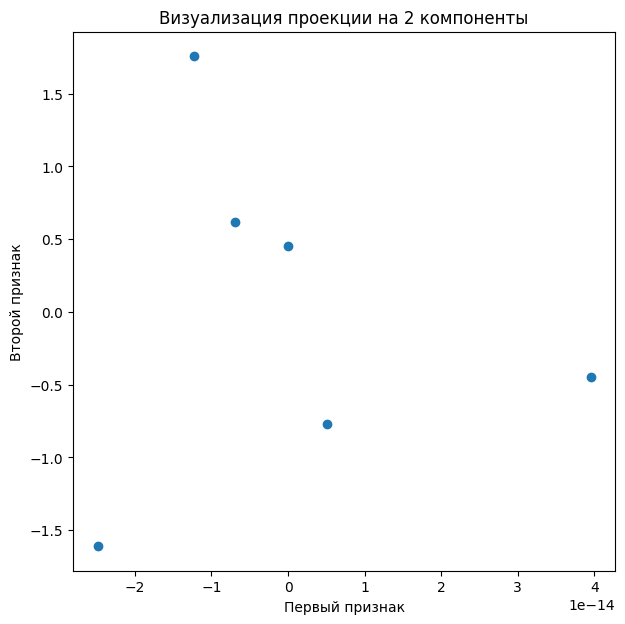

In [25]:
random.seed(42)
C = Matrix([
    [round(random.uniform(-10, 10), 2) for _ in range(6)]
    for _ in range(6)
])

C_pca, dispersion_ratio = pca(C, k=5)
plot_pca_projection(C_pca)

# Задание (Hard): Вычислить среднеквадратическую ошибку восстановления данных

In [26]:
def reconstruction_error(X_orig: Matrix, X_recon: Matrix) -> float:
    """Вычисляет среднеквадратическую ошибку восстановления данных.
    Args:
        X_orig (Matrix): исходные данные (n×m).
        X_recon (Matrix): восстановленные данные (n×m).
    Returns:
        (float): среднеквадратическая ошибка MSE.
    Raises:
        (ValueError): если размеры матриц не совпадают.
    """
    if X_orig.n_rows != X_recon.n_rows or X_orig.n_cols != X_recon.n_cols:
        raise ValueError("У матриц не совпадают размеры.")
    err_matr = X_orig.add_matrix(X_recon.multiply_by_scalar(-1))
    mse = (err_matr.norm())**2 / (X_orig.n_rows * X_orig.n_cols)
    return mse

In [27]:
def test_reconstruction_error_zero():
    """Проверяет, что при идентичных матрицах MSE равна 0."""
    X = Matrix([[1, 2], [3, 4]])
    X_recon = Matrix([[1, 2], [3, 4]])
    mse = reconstruction_error(X, X_recon)
    assert abs(mse - 0.0) < 1e-12

def test_reconstruction_error_known_value():
    """Проверяет вычисление MSE для простого примера 2×2."""
    X = Matrix([[1, 2], [3, 4]])
    X_recon = Matrix([[2, 2], [2, 2]])
    # Разности: [[-1, 0], [1, 2]]. MSE = 6 / 4 = 1.5
    mse = reconstruction_error(X, X_recon)
    assert abs(mse - 1.5) < 1e-12

def test_reconstruction_error_dimension_mismatch():
    """Проверяет, что при различных размерах матриц выбрасывается ValueError."""
    X = Matrix([[1, 2, 3], [4, 5, 6]])
    X_recon = Matrix([[1, 2], [3, 4]])
    try:
        reconstruction_error(X, X_recon)
        assert False, "Ожидалась ошибка ValueError"
    except ValueError:
        pass

# Задание (Expert): Обработать пропущенные значения в данных

In [28]:
def handle_missing_values(X: Matrix) -> Matrix:
    """
    Args:
        X (Matrix): матрица данных X (n×m) с возможными NaN.
    Returns:
        (Matrix): матрица данных X_filled (n×m) без NaN.
    """
    X_means = X.column_means()
    X_filled = [
        [X_means[j] if X[i][j] == None else X[i][j] for j in range(X.n_cols)]
        for i in range(X.n_rows)
    ]
    return Matrix(X_filled)

In [29]:
C = Matrix([[1,0,None], [0,2,0], [0,0,1]])
C_filled = handle_missing_values(C)
print(C)
print(C_filled)

Matrix(
 [1 0 None
  0 2 0
  0 0 1])
Matrix(
 [1 0 0.5
  0 2 0
  0 0 1])


# Отступление. Нахождение с.з. и с.в. через степенной метод

In [30]:
def power_method(M: Matrix, N_iters: int=10, tol: float=1e-6):
    """Функция для степенного метода нахождения собственного значения и вектора.
    Args:
        M (Matrix): матрица, для которой находим с.в.
        N_iters(int): кол-во итераций алгоритма.
    Returns:
        tuple(float, Matrix): кортеж из собственного значения[0] и вектора[1]
    """
    random.seed(42)
    x = Matrix([
        [round(random.uniform(-10, 10), 2)] for _ in range(M.n_cols)
    ])
    x = x.multiply_by_scalar(1/x.norm())

    for _ in range(N_iters):
        Mx = M.multiply_by_matrix(x)
        try:
            x_new = Mx.multiply_by_scalar(1/Mx.norm())
        except ZeroDivisionError:
            break

        # Проверка сходимости
        unb = x_new.add_matrix(x.multiply_by_scalar(-1))
        if unb.norm() < tol:
            break
        x = x_new

    ev = Mx.transpose().multiply_by_matrix(x).to_list()[0][0]
    return ev, x.multiply_by_scalar(-1)

In [31]:
def find_ev_evectors_pm(M: Matrix, k: int, N_iters: int=10,
                        is_already_centered: bool=False) -> tuple[List[float], List[float]]:
    """Функция для нахождения с.з. и с.в. степенным методом.
    Args:
        M (Matrix): матрица, для которой находим с.в.
        k (int): кол-во с.з. и векторов, которое нужно найти.
        N_iters(int): кол-во итераций алгоритма.
        is_already_centered (bool): показывает, квадратна (центрированна в нашем
            случае) уже матрица.
    Returns:
        tuple(List[float], List[float]): кортеж из собственного значений[0] и векторов[1]
    """
    if k > min(M.n_rows, M.n_cols):
        k = min(M.n_rows, M.n_cols)
    if not is_already_centered:
        M = M.multiply_by_matrix(M.transpose())

    evalues, evectors = [], []
    for i in range(k):
        ev, u = power_method(M, N_iters=N_iters)

        evalues.append(ev**0.5)
        evectors.append(u.to_list(like_vector=True))
        # Обновляем матрицу для следующих с.в. и с.з.
        ev_x_uut = (u.multiply_by_matrix(u.transpose())).multiply_by_scalar(ev)
        M = M.add_matrix(ev_x_uut.multiply_by_scalar(-1))

    return [evalues, evectors]

In [32]:
C = Matrix([[3,0,0], [0,2,0], [0,0,1]])
evalues, evectors = find_ev_evectors_pm(C, k=3, N_iters=100)
print('evals: ', evalues)
for i in range(len(evectors)):
    print(f'evector {i+1}: ', evectors[i])

evals:  [2.9999999999979745, 2.000000000006682, 1.0000000000012244]
evector 1:  [-0.9999999999987847, 1.558956783196334e-06, 1.0745908557044465e-17]
evector 2:  [3.5076527621666786e-06, 0.9999999999937462, 4.517409309953846e-07]
evector 3:  [3.0788359331783253e-12, -1.8069676038567187e-06, 0.9999999999983674]


In [33]:
def pca_with_pm(X: Matrix, k: int=None, N_iters: int=10,
                threshold: float=0.95,
                return_components: bool=False) -> tuple[Matrix, float]:
    """Без автоматического выбора k.
    Args:
        X (Matrix): матрица данных (n×m).
        k (int): число главных компонент.
        N_iters (int): кол-во итераций алгоритма.
        threshold (float): порог объяснённой дисперсии (если выбираем k автоматически).
        return_components (bool): вернуть ли компоненты.
    Returns:
        List(Matrix, Matrix, float): проекция данных (n×k),
            матрица компонент, доля объяснённой дисперсии.
    """
    if k > X.n_cols:
        raise ValueError("Число k больше, чем число столбцов матрицы X.")
    X_centered = center_data(X)

    X_cov = covariance_matrix(X_centered)

    eigenvalues, eigenvectors = find_ev_evectors_pm(X_cov, k=k, N_iters=N_iters,
                                      is_already_centered=True)

    pca_components = Matrix(eigenvectors).transpose()

    project_data = X_centered.multiply_by_matrix(pca_components)
    dispersion_ratio = explained_variance_ratio(eigenvalues, k=k)
    if return_components:
        return [project_data, pca_components, dispersion_ratio]
    return project_data, dispersion_ratio

In [34]:
def test_pca_with_pm_basic():
    """Проверяет базовый случай PCA с двумя признаками и k=1."""
    X = Matrix([[1, 2], [2, 3], [3, 4]])
    k = 1
    projected, ratio = pca_with_pm(X, k, N_iters=1000)
    # Ожидаемые центрированные данные: [[-1, -1], [0, 0], [1, 1]]
    # Главный компонент [1/sqrt(2), 1/sqrt(2)], Проекция: [-sqrt(2), 0, sqrt(2)]
    expected_projection = [[-2**0.5], [0], [2**0.5]]
    for i in range(len(projected)):
        assert abs(projected[i][0] - expected_projection[i][0]) < 1e-10

    assert ratio == 1.0

def test_pca_with_pm_zero_variance():
    """Проверяет обработку случая, когда все данные одинаковы."""
    X = Matrix([[5, 5], [5, 5], [5, 5]])
    k = 1
    try:
        pca_with_pm(X, k)
        assert False, "Ожидалась ZeroDivisionError"
    except ZeroDivisionError:
        pass

def test_pca_with_pm_invalid_k():
    """Проверяет обработку случая, когда k больше числа признаков."""
    X = Matrix([[1, 2], [3, 4]])
    k = 3
    try:
        pca_with_pm(X, k)
        assert False, "Ожидалась ValueError"
    except ValueError:
        pass

def test_pca_with_pm_correct_projection_dimensions():
    """Проверяет корректность размерности проекции."""
    n, m, k = 5, 3, 2
    X = Matrix([[float(i + j) for j in range(m)] for i in range(n)])
    projected, _ = pca_with_pm(X, k)
    assert len(projected) == n
    assert len(projected[0]) == k

def test_pca_with_pm_variance_ratio_multiple_components():
    """Проверяет долю дисперсии для нескольких компонент."""
    X = Matrix([[2, 0, 0], [4, 0, 0], [6, 0, 0], [8, 0, 0]])
    k = 2
    _, ratio = pca_with_pm(X, k)

    assert ratio == 1.0

test_pca_with_pm_basic()
test_pca_with_pm_zero_variance()
test_pca_with_pm_invalid_k()
test_pca_with_pm_correct_projection_dimensions()
test_pca_with_pm_variance_ratio_multiple_components()

# Задание (Expert): Исследовать влияние шума на PCA

In [35]:
def add_noise_and_compare(X: Matrix, k: int, noise_level: float=0.1):
    """
    Args:
        X (Matrix): матрица данных (n×m)
        noise_level (float): уровень шума (доля от стандартного отклонения)
    Returns:
        результаты PCA до и после добавления шума.
    """
    stds = X.std()

    noisy_data = []
    for row in X.data:
        noisy_row = [
            val + random.gauss(0, 1) * noise_level * stds[j]
            for j, val in enumerate(row)
        ]
        noisy_data.append(noisy_row)
    X_noisy = Matrix(noisy_data)

    proj_orig, var_orig = pca_with_pm(X, k=k)
    proj_noisy, var_noisy = pca_with_pm(X_noisy, k=k)

    return [proj_orig, var_orig, proj_noisy, var_noisy]

In [36]:
X = Matrix([[1,0,0], [0,2,0], [0,2,3]])
k = 2
proj_orig, var_orig, proj_noisy, var_noisy = add_noise_and_compare(X, k)
print(proj_orig)
print(var_orig)
print(proj_noisy)
print(var_noisy)

Matrix(
 [-1.60577 -0.802309
  -0.501399 1.142
  2.10717 -0.33969])
1.0
Matrix(
 [-1.65732 -0.742049
  -0.412943 1.11392
  2.07026 -0.371868])
1.0


# Задание (Expert): Применить PCA к реальному датасету

In [37]:
from sklearn.datasets import load_digits, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def apply_pca_to_dataset(dataset_name: str, k: int,
                         pca_type: str='bisection',
                         N_iters: int=10,
                         features_before_PCA: int=None) -> tuple[Matrix, float, float]:
    """
    Args:
        dataset_name (str): название датасета
        k (int): число главных компонент
        pca_type (str): какой метод для вычисления с.з. и с.в. использовать.
            Доступны: {bisection, pm}
        N_iters (int): кол-во итераций степенного метода, если используем его.
        features_before_PCA (int): сколько признаков до PCA нужно оставить.
    Retuns:
        tuple(Matrix, float, float): проекция данных, качество модели с проекцией,
            без PCA
    """
    dataset_loader = {
        'digits': load_digits,
        'wine': load_wine,
        'breast_cancer': load_breast_cancer
    }.get(dataset_name.lower())

    if not dataset_loader:
        raise ValueError(f"Датасет {dataset_name} не найден. Доступные варианты: {list(dataset_loader.keys())}")

    data = dataset_loader()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if k > len(X[0]):
        k = len(X[0])

    # Если нужно уменьшить кол-во признаков
    if features_before_PCA:
        X_tr_comp = []
        X_te_comp = []
        for i in range(len(X_train)):
            X_tr_comp.append(X_train[i][:features_before_PCA].tolist())
        X_train = X_tr_comp
        for i in range(len(X_test)):
            X_te_comp.append(X_test[i][:features_before_PCA].tolist())
        X_test = X_te_comp

        matrix_X_train = Matrix(X_train)
        matrix_X_test = Matrix(X_test)
    else:
        matrix_X_train = Matrix(X_train.tolist())
        matrix_X_test = Matrix(X_test.tolist())

    if pca_type == 'pm':
        X_train_projected, pca_components, _ = pca_with_pm(matrix_X_train, k=k,
                                                           return_components=True)
    else:
        X_train_projected, pca_components, _ = pca(matrix_X_train, k=k,
                                                   return_components=True)

    # Центрируем по train
    X_test_centered = center_data(matrix_X_test, means=matrix_X_train.column_means())

    X_test_projected = X_test_centered.multiply_by_matrix(pca_components)

    # Обучение и оценка
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train_projected.to_list(), y_train)
    y_pred_proj = logreg.predict(X_test_projected.to_list())

    logreg.fit(X_train, y_train)
    y_pred_orig = logreg.predict(X_test)

    X_all_projected = Matrix(X_train_projected.data + X_test_projected.data)

    return [X_all_projected,
            accuracy_score(y_test, y_pred_proj),
            accuracy_score(y_test, y_pred_orig)]

In [38]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [39]:
for k in range(1,5):
    projection, acc_proj, acc_orig = apply_pca_to_dataset('wine', k=k,
                                                          pca_type='bisection',
                                                          features_before_PCA=7)
    print(f'k = {k}')
    print(f"Accuracy до PCA: {acc_orig:.3f}")
    print(f"Accuracy после PCA: {acc_proj:.3f}")

k = 1
Accuracy до PCA: 0.944
Accuracy после PCA: 0.528
k = 2
Accuracy до PCA: 0.944
Accuracy после PCA: 0.694
k = 3
Accuracy до PCA: 0.944
Accuracy после PCA: 0.694
k = 4
Accuracy до PCA: 0.944
Accuracy после PCA: 0.694


In [40]:
for k in range(1,5):
    projection, acc_proj, acc_orig = apply_pca_to_dataset('breast_cancer', k=k,
                                                          pca_type='pm')
    print(f'k = {k}')
    print(f"Accuracy до PCA: {acc_orig:.3f}")
    print(f"Accuracy после PCA: {acc_proj:.3f}")

k = 1
Accuracy до PCA: 0.956
Accuracy после PCA: 0.939
k = 2
Accuracy до PCA: 0.956
Accuracy после PCA: 0.965
k = 3
Accuracy до PCA: 0.956
Accuracy после PCA: 0.974
k = 4
Accuracy до PCA: 0.956
Accuracy после PCA: 0.965


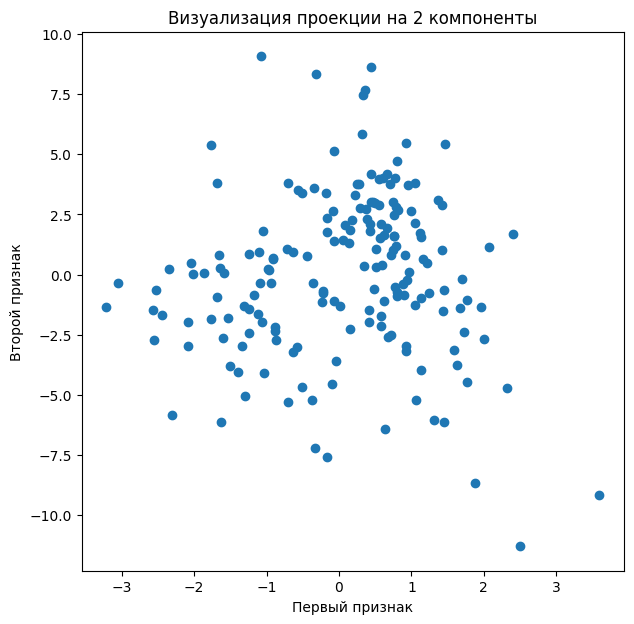

In [41]:
proj_2, _, _= apply_pca_to_dataset('wine', k=2, pca_type='bisection',
                                   features_before_PCA=7)
plot_pca_projection(proj_2)

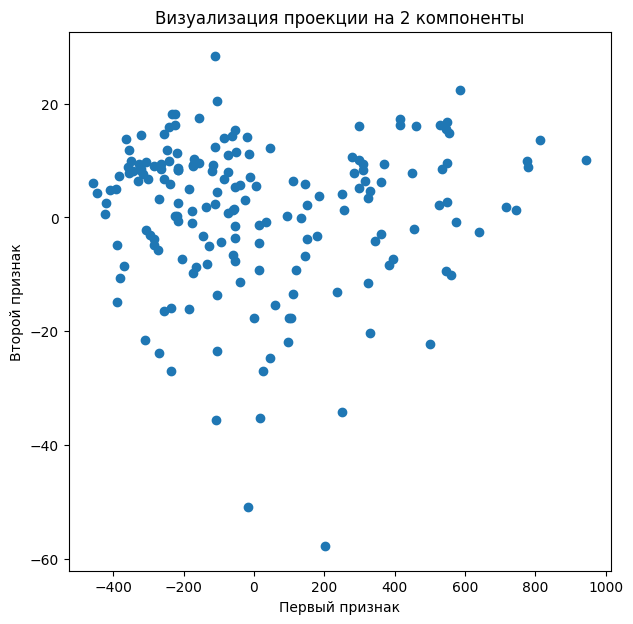

In [42]:
iris_proj_2, _, _= apply_pca_to_dataset('wine', k=2, pca_type='pm')
plot_pca_projection(iris_proj_2)